In [1]:
#get vectors from primary experiments (large file - 2.8GB compressed)
!wget https://zenodo.org/record/3283012/files/vecsRedux10takes.tar.gz

--2019-07-12 12:31:09--  https://zenodo.org/record/3283012/files/vecsRedux10takes.tar.gz
Resolving zenodo.org... 188.184.65.20
Connecting to zenodo.org|188.184.65.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2765572742 (2.6G) [application/octet-stream]
Saving to: ‘vecsRedux10takes.tar.gz’

vecsRedux10takes.ta 100%[===================>]   2.58G  11.8MB/s    in 5m 17s  

2019-07-12 12:36:27 (8.33 MB/s) - ‘vecsRedux10takes.tar.gz’ saved [2765572742/2765572742]



In [3]:
!tar xzf vecsRedux10takes.tar.gz

In [4]:
!ls vecsRedux10takes

take1  take10 take2  take3  take4  take5  take6  take7  take8  take9


In [5]:
import pandas as pd
import numpy as np

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

## aer2vec+

In [7]:
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

def getframe(input_vectors,output_vectors,refset):
    df = pd.DataFrame()
    missing = 0
    for i in range(0,len(refset.loc[:,1]),1):
        ade=refset.loc[i,0]
        drug=refset.loc[i,1]
        if (drug in output_vectors):
            label=refset.loc[i,2]
            sigscalar = 1 / (1 + np.exp(-np.dot(input_vectors[ade], output_vectors[drug])))
            cosine = np.dot(input_vectors[ade], output_vectors[drug])/(np.linalg.norm(input_vectors[ade])*np.linalg.norm(output_vectors[drug]))
            df = df.append({"Drug":drug,"ADE":ade,"label":label,"cosine":cosine,"sigscalar":sigscalar}, ignore_index=True)
        else:
            missing = missing + 1
    print('Could not represent ',missing,' example pairs.')
    return df

In [8]:
import matplotlib.pyplot as plt
from operator import add
import numpy as np
from scipy import interp

def getplots(dfs, label):
    plt.title(str(label)+' Receiver Operating Characteristic')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    aucs=0
    ap=0
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i in range(10):
        df=dfs[i]
        labels=np.array(pd.to_numeric(df['label']))
        scores=np.array(df['sigscalar'])
        fpr, tpr, _ = roc_curve(labels,scores)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        #plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        pscore=average_precision_score(labels,scores)
        precision, recall, thresholds = precision_recall_curve(labels,scores)
        aucs += roc_auc
        area = auc(recall, precision)
        ap  += area

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'mean ROC (AUC = '+"{:0.3f}".format(aucs/10)+')',lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + 1.96*std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - 1.96*std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
    plt.legend(loc = 'lower right')
    plt.show()
    
    aucs /= 10
    ap  /= 10
    print(label)
    print('mean auroc',aucs)
    print('mean auprc',ap)
    
def getstats(dfs, label):
    aucs=[]
    aps=[]
    
    for i in range(10):
        df=dfs[i]
        labels=np.array(pd.to_numeric(df['label']))
        scores=np.array(df['sigscalar'])
        fpr, tpr, _ = roc_curve(labels,scores)
        roc_auc = auc(fpr, tpr)
        pscore=average_precision_score(labels,scores)
        precision, recall, thresholds = precision_recall_curve(labels,scores)
        area = auc(recall, precision)
        aucs.append(roc_auc)
        aps.append(area)
        

    return(aucs,aps)
    

Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.


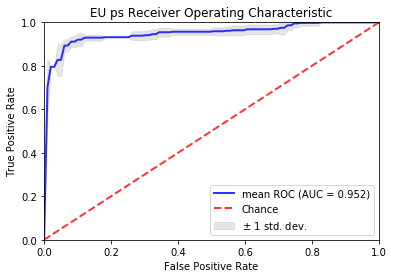

EU ps
mean auroc 0.951590909090909
mean auprc 0.9604398765961862
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.


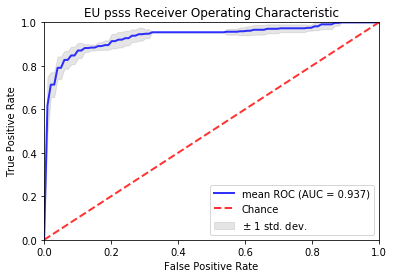

EU psss
mean auroc 0.9369545454545454
mean auprc 0.9462888277752292
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.
Could not represent  0  example pairs.


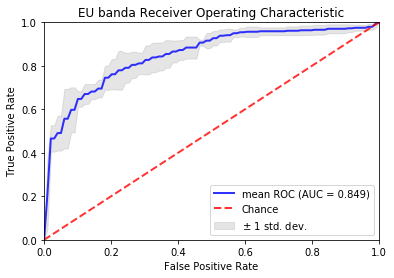

EU banda
mean auroc 0.8490909090909092
mean auprc 0.8484473586225038


In [9]:
evalset='cleanEU.csv'
refset = pd.read_csv(evalset,skiprows=0,header=None)
refset.loc[:,1]=">"+refset.loc[:,1]

eustats=[]

for h in ['ps','psss','banda']:
    dfs=[]
    for i in range(1,11):
        inputfile= 'vecsRedux10takes/take'+str(i)+'/'+str(h)+'/inputweightvectors.txt'
        outputfile= 'vecsRedux10takes/take'+str(i)+'/'+str(h)+'/outputweightvectors.txt'
        incoming_vectors = pd.read_csv(inputfile, skiprows=1,sep='|',header=None)
        input_vectors = incoming_vectors.set_index(0).T.to_dict('list')
        outgoing_vectors = pd.read_csv(outputfile, skiprows=1,sep='|',header=None)
        output_vectors = outgoing_vectors.set_index(0).T.to_dict('list')
        dfs.append(getframe(input_vectors,output_vectors,refset))

    getplots(dfs,'EU '+str(h))
    eustats.append(getstats(dfs, 'EU '+str(h)))

In [10]:
import statistics
labels1=['auroc','auprc']
labels2=['ps\t','psss','full']

for i in range(3):
    for j in range(2):
        print(labels2[i],labels1[j],'\t',"{:0.3f}".format(np.average(eustats[i][j]),4),'\t+-',"{:0.3f}".format(1.96*statistics.stdev(eustats[i][j]),5))

ps	 auroc 	 0.952 	+- 0.005
ps	 auprc 	 0.960 	+- 0.003
psss auroc 	 0.937 	+- 0.006
psss auprc 	 0.946 	+- 0.006
full auroc 	 0.849 	+- 0.024
full auprc 	 0.848 	+- 0.033


Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.


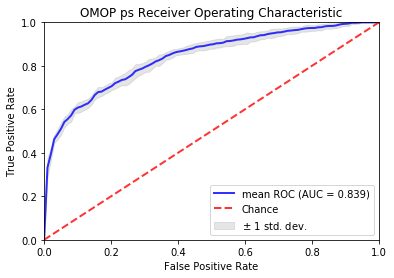

OMOP ps
mean auroc 0.8388755277644165
mean auprc 0.8089878387531151
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.
Could not represent  6  example pairs.


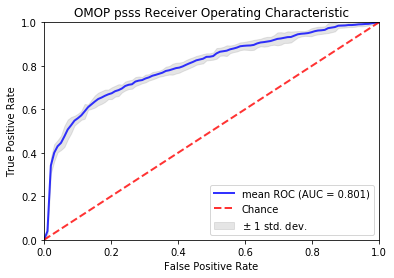

OMOP psss
mean auroc 0.8006119395008284
mean auprc 0.7586298709980097
Could not represent  1  example pairs.
Could not represent  1  example pairs.
Could not represent  1  example pairs.
Could not represent  1  example pairs.
Could not represent  1  example pairs.
Could not represent  1  example pairs.
Could not represent  1  example pairs.
Could not represent  1  example pairs.
Could not represent  1  example pairs.
Could not represent  1  example pairs.


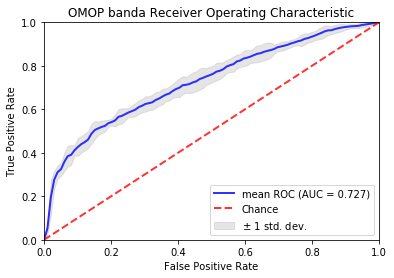

OMOP banda
mean auroc 0.7268607231431928
mean auprc 0.6786492012552439


In [11]:
evalset='cleanRyan.csv'
refset = pd.read_csv(evalset,skiprows=0,header=None)
refset.loc[:,1]=">"+refset.loc[:,1]

omopstats=[]

for h in ['ps','psss','banda']:
    dfs=[]
    for i in range(1,11):
        inputfile= 'vecsRedux10takes/take'+str(i)+'/'+str(h)+'/inputweightvectors.txt'
        outputfile= 'vecsRedux10takes/take'+str(i)+'/'+str(h)+'/outputweightvectors.txt'
        incoming_vectors = pd.read_csv(inputfile, skiprows=1,sep='|',header=None)
        input_vectors = incoming_vectors.set_index(0).T.to_dict('list')
        outgoing_vectors = pd.read_csv(outputfile, skiprows=1,sep='|',header=None)
        output_vectors = outgoing_vectors.set_index(0).T.to_dict('list')
        dfs.append(getframe(input_vectors,output_vectors,refset))

    getplots(dfs,'OMOP '+str(h))
    omopstats.append(getstats(dfs, 'OMOP '+str(h)))

In [12]:
import statistics
labels1=['auroc','auprc']
labels2=['ps\t','psss','full']

for i in range(3):
    for j in range(2):
        print(labels2[i],labels1[j],'\t',"{:0.3f}".format(np.average(omopstats[i][j]),4),'\t+-',"{:0.3f}".format(1.96*statistics.stdev(omopstats[i][j]),5))

ps	 auroc 	 0.839 	+- 0.007
ps	 auprc 	 0.809 	+- 0.005
psss auroc 	 0.801 	+- 0.008
psss auprc 	 0.759 	+- 0.008
full auroc 	 0.727 	+- 0.016
full auprc 	 0.679 	+- 0.019


In [13]:
import scipy.stats
labels2=['ps\t','psss','full']

print("EU-ADR")
for i in range(3):
    for j in range(i+1,3):
        tres=scipy.stats.ttest_ind(eustats[i][0],eustats[j][0])
        print(labels2[i],":",labels2[j],"\t",tres)
print("OMOP")
for i in range(3):
    for j in range(i+1,3):
        tres=scipy.stats.ttest_ind(omopstats[i][0],omopstats[j][0])
        print(labels2[i],":",labels2[j],"\t",tres)

EU-ADR
ps	 : psss 	 Ttest_indResult(statistic=11.524525513035377, pvalue=9.647924358685261e-10)
ps	 : full 	 Ttest_indResult(statistic=25.92258470745129, pvalue=1.0504053912400391e-15)
psss : full 	 Ttest_indResult(statistic=21.85564836585655, pvalue=2.0711728747011095e-14)
OMOP
ps	 : psss 	 Ttest_indResult(statistic=22.97958096067482, pvalue=8.651616506669465e-15)
ps	 : full 	 Ttest_indResult(statistic=39.37537005435573, pvalue=6.439046214766527e-19)
psss : full 	 Ttest_indResult(statistic=25.547166703000315, pvalue=1.3568438119707237e-15)


## aer2vec-

In [14]:
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

def getswitchframe(input_vectors,output_vectors,refset):
    missing = 0
    df = pd.DataFrame()
    for i in range(0,len(refset.loc[:,1]),1):
        ade=refset.loc[i,0]
        drug=refset.loc[i,1]
        if (drug in input_vectors):
            label=refset.loc[i,2]
            sigscalar = 1 / (1 + np.exp(-np.dot(output_vectors[ade], input_vectors[drug])))
            cosine = np.dot(output_vectors[ade], input_vectors[drug])/(np.linalg.norm(output_vectors[ade])*np.linalg.norm(input_vectors[drug]))
            df = df.append({"Drug":drug,"ADE":ade,"label":label,"cosine":cosine,"sigscalar":sigscalar}, ignore_index=True)
        else:
            missing = missing + 1
    print("Could not represent ",missing," examples.")
    return df

Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.


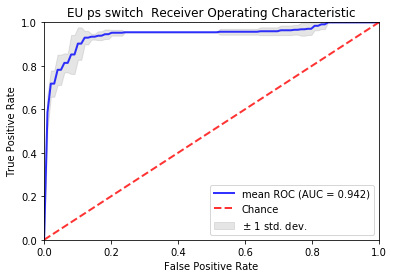

EU ps switch 
mean auroc 0.9419090909090908
mean auprc 0.9503004713522648
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.


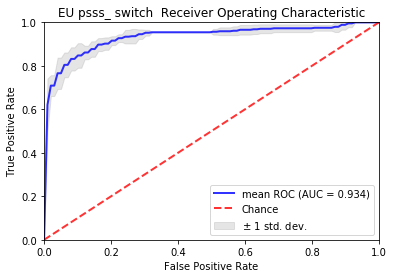

EU psss_ switch 
mean auroc 0.9344545454545454
mean auprc 0.9441063727249285
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.
Could not represent  0  examples.


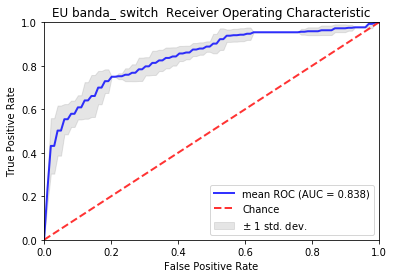

EU banda_ switch 
mean auroc 0.8375909090909092
mean auprc 0.8420519707769667


In [15]:
evalset='cleanEU.csv'
refset = pd.read_csv(evalset,skiprows=0,header=None)
refset.loc[:,0]=">"+refset.loc[:,0]

euswitchstats=[]

for h in ['ps','psss_','banda_']:
    dfs=[]
    for i in range(1,11):
        inputfile= 'vecsRedux10takes/take'+str(i)+'/'+str(h)+'switch/inputweightvectors.txt'
        outputfile= 'vecsRedux10takes/take'+str(i)+'/'+str(h)+'switch/outputweightvectors.txt'
        incoming_vectors = pd.read_csv(inputfile, skiprows=1,sep='|',header=None)
        input_vectors = incoming_vectors.set_index(0).T.to_dict('list')
        outgoing_vectors = pd.read_csv(outputfile, skiprows=1,sep='|',header=None)
        output_vectors = outgoing_vectors.set_index(0).T.to_dict('list')
        dfs.append(getswitchframe(input_vectors,output_vectors,refset))

    getplots(dfs,'EU '+str(h)+' switch ')
    euswitchstats.append(getstats(dfs,'EU '+str(h)+' switch '))

In [16]:
import statistics
labels1=['auroc','auprc']
labels2=['ps\t','psss','full']

for i in range(3):
    for j in range(2):
        print(labels2[i],labels1[j],'\t',"{:0.3f}".format(np.average(euswitchstats[i][j]),4),'\t+-',"{:0.3f}".format(1.96*statistics.stdev(euswitchstats[i][j]),5))

ps	 auroc 	 0.942 	+- 0.007
ps	 auprc 	 0.950 	+- 0.007
psss auroc 	 0.934 	+- 0.007
psss auprc 	 0.944 	+- 0.008
full auroc 	 0.838 	+- 0.015
full auprc 	 0.842 	+- 0.019


Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.


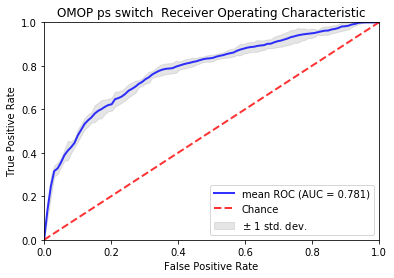

OMOP ps switch 
mean auroc 0.7814226925338037
mean auprc 0.7293163657660868
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.
Could not represent  6  examples.


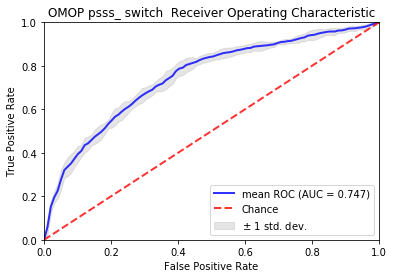

OMOP psss_ switch 
mean auroc 0.7467345411789856
mean auprc 0.6628300423734299
Could not represent  1  examples.
Could not represent  1  examples.
Could not represent  1  examples.
Could not represent  1  examples.
Could not represent  1  examples.
Could not represent  1  examples.
Could not represent  1  examples.
Could not represent  1  examples.
Could not represent  1  examples.
Could not represent  1  examples.


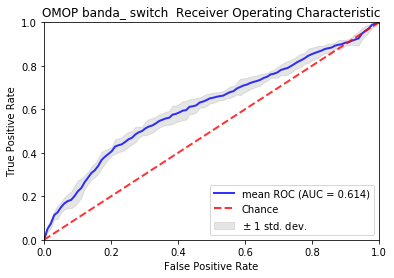

OMOP banda_ switch 
mean auroc 0.6140529956924683
mean auprc 0.5398223794955307


In [17]:
evalset='cleanRyan.csv'
refset = pd.read_csv(evalset,skiprows=0,header=None)
refset.loc[:,0]=">"+refset.loc[:,0]

omopswitchstats = []

for h in ['ps','psss_','banda_']:
    dfs=[]
    for i in range(1,11):
        inputfile= 'vecsRedux10takes/take'+str(i)+'/'+str(h)+'switch/inputweightvectors.txt'
        outputfile= 'vecsRedux10takes/take'+str(i)+'/'+str(h)+'switch/outputweightvectors.txt'
        incoming_vectors = pd.read_csv(inputfile, skiprows=1,sep='|',header=None)
        input_vectors = incoming_vectors.set_index(0).T.to_dict('list')
        outgoing_vectors = pd.read_csv(outputfile, skiprows=1,sep='|',header=None)
        output_vectors = outgoing_vectors.set_index(0).T.to_dict('list')
        dfs.append(getswitchframe(input_vectors,output_vectors,refset))

    getplots(dfs,'OMOP '+str(h)+' switch ')
    omopswitchstats.append(getstats(dfs,'OMOP '+str(h)+' switch '))

In [20]:
import statistics
labels1=['auroc','auprc']
labels2=['ps\t','psss','full']

for i in range(3):
    for j in range(2):
        print(labels2[i],labels1[j],'\t',"{:0.3f}".format(np.average(omopswitchstats[i][j]),4),'\t+-',"{:0.3f}".format(1.96*statistics.stdev(omopswitchstats[i][j]),5))

ps	 auroc 	 0.781 	+- 0.007
ps	 auprc 	 0.729 	+- 0.008
psss auroc 	 0.747 	+- 0.010
psss auprc 	 0.663 	+- 0.011
full auroc 	 0.614 	+- 0.015
full auprc 	 0.540 	+- 0.017


In [18]:
import scipy.stats
labels2=['ps\t','psss','full']

print("EU-ADR")
for i in range(3):
    for j in range(i+1,3):
        tres=scipy.stats.ttest_ind(euswitchstats[i][0],euswitchstats[j][0])
        print(labels2[i],":",labels2[j],"\t",tres)
print("OMOP")
for i in range(3):
    for j in range(i+1,3):
        tres=scipy.stats.ttest_ind(omopswitchstats[i][0],omopswitchstats[j][0])
        print(labels2[i],":",labels2[j],"\t",tres)

EU-ADR
ps	 : psss 	 Ttest_indResult(statistic=4.740421185816465, pvalue=0.00016333677647198972)
ps	 : full 	 Ttest_indResult(statistic=39.08085679607997, pvalue=7.3598192283678285e-19)
psss : full 	 Ttest_indResult(statistic=36.46481091203548, pvalue=2.523862977382052e-18)
OMOP
ps	 : psss 	 Ttest_indResult(statistic=18.110271173844396, pvalue=5.304740493549408e-13)
ps	 : full 	 Ttest_indResult(statistic=63.27425588666568, pvalue=1.3396262949459064e-22)
psss : full 	 Ttest_indResult(statistic=46.80960743935127, pvalue=2.946577798397821e-20)


In [19]:
#compare same configuration (e.g. PS-PS) across aer2vec+ and aer2vec-
labels2=['ps\t','psss','full']

print("EU-ADR")
for j in range(3):
    tres=scipy.stats.ttest_ind(eustats[j][0],euswitchstats[j][0])
    print(labels2[j],":",labels2[j],"\t",tres)

print("OMOP")
for j in range(3):
    tres=scipy.stats.ttest_ind(omopstats[j][0],omopswitchstats[j][0])
    print(labels2[j],":",labels2[j],"\t",tres)

EU-ADR
ps	 : ps	 	 Ttest_indResult(statistic=7.188856710384001, pvalue=1.0848702975126598e-06)
psss : psss 	 Ttest_indResult(statistic=1.6585637117503296, pvalue=0.11452721817303621)
full : full 	 Ttest_indResult(statistic=2.5127353965705725, pvalue=0.02172478873588933)
OMOP
ps	 : ps	 	 Ttest_indResult(statistic=35.75952854502744, pvalue=3.570835502188407e-18)
psss : psss 	 Ttest_indResult(statistic=27.42288705838561, pvalue=3.907097254713581e-16)
full : full 	 Ttest_indResult(statistic=31.896195052138115, pvalue=2.7120808360436745e-17)
